In [107]:
%pip install mpqp

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from mpqp import QCircuit
from mpqp.gates import H

def prepare_initial_state(n_precision_qubits, eigenstate_circuit):
    # Create an empty circuit with total number of qubits
    n_eigenstate_qubits = eigenstate_circuit.nb_qubits
    total_qubits = n_precision_qubits + n_eigenstate_qubits
    circ = QCircuit(nb_qubits=total_qubits, label="QPE Circuit")

    # Define the precision qubits and the circuits qubits range indices
    precisions = range(n_precision_qubits)
    circuits = range(n_precision_qubits, total_qubits)

    # Apply Hadamard gates to precision qubits (index 0 to n-1)
    for i in range(n_precision_qubits):
        circ.add(H(i))

    # Append the given eigenstate circuit offset to the "bottom" qubits
    circ.append(eigenstate_circuit, qubits_offset=n_precision_qubits)

    # Return circuit in state |+>^n \otimes |eigenstate>
    return circ, precisions, circuits

In [ ]:
from mpqp import QCircuit
from mpqp.gates import CNOT, TOF, ControlledGate

def controlled_unitary(circuit, unitary, control_qubit, offset):
    # cu_circuit = QCircuit(nb_qubits=10) # TODO fix
    cu_circuit = QCircuit(nb_qubits=circuit.nb_qubits, label="Controlled Unitary Circuit")

    for gate in unitary.gates:
        print(f"Processing gate {gate}")
        if len(gate.targets) == 1: # Single target gate
            target = gate.targets[0] + target_offset
            if isinstance(gate, CNOT): # CNOT -> TOF
                control = gate.controls[0] + target_offset
                cu_circuit.add(TOF([control_qubit, control], target))
            else: # Other single target gates becomes controlled versions
                cu_circuit.add(ControlledGate([control_qubit], [target], gate))
    return cu_circuit

In [ ]:
def apply_controlled_unitary_powers(initial_circuit, precisions, eigenstate_qubits, unitary):
    # Loop through precision qubits in reverse order
    for i in precisions[::-1]:
        # Apply controlled unitary operator 2^(n-i-1) times (1, 2, 4, ...)
        for _ in range(2 ** (len(precisions) - i - 1)):
            controlled_unitary(initial_circuit, i, len(precisions), unitary)


In [ ]:
from mpqp.gates import *
from mpqp.execution.result import Result
from mpqp import QCircuit, Barrier
from mpqp.execution import run, IBMDevice
from math import floor
import numpy as np


class InverseQFT(QCircuit):

    def __init__(self,n_qubits):
        super().__init__(n_qubits, nb_cbits=n_qubits)
        self._build()

    def _build(self):
        self.add([SWAP(i, self.nb_qubits - 1 - i)
            for i in range(int(floor(self.nb_qubits / 2)))])
        j = self.nb_qubits - 1
        while j >= 0:
            self.add(Barrier())
            self.add([CRk(i+1 - j, i, j).inverse() for i in range(j+1, self.nb_qubits)])
            self.add(H(j))
            j -= 1

In [190]:
from mpqp.measures import BasisMeasure
from numpy import pi as PI

def QPE(unitary, eigenstate_circuit, n_precision_qubits):
    # n = number of precision qubits
    # m = number of eigenstate qubits
    # unitary = unitary circuit to apply
    # eigenstate_circuit = circuit that prepares the initial eigenstate

    #### 1. Prepare the initial state |+>^n \otimes |eigenstate> ####
    # Create an empty circuit with total number of qubits
    n, m = n_precision_qubits, eigenstate_circuit.nb_qubits
    total_qubits = n + m
    circ = QCircuit(nb_qubits=total_qubits, label="QPE Circuit")
    precisions = range(n)

    # Apply Hadamard gates to precision qubits (index 0 to n-1)
    for i in range(n_precision_qubits):
        circ.add(H(i))

    # Append the given eigenstate circuit offset to the "bottom" qubits
    circ.append(eigenstate_circuit, qubits_offset=n_precision_qubits)
    circ.add(Barrier())
    print("Initial state prepared: |+>^n otimes |eigenstate>")

    #### 2. Apply controlled unitary operators ####
    # Loop through precision qubits in reverse order
    print("Applying controlled unitary operations.")
    precisions = range(n)
    for i in precisions[::-1]:
        print(f"Applying controlled unitary for precision qubit {i}")
        # Apply controlled unitary operator 2^(n-i-1) times (1, 2, 4, ...)
        iterations = 2 ** (n - i - 1)
        print(f"Applying controlled unitary {iterations} times.")
        for k in range(iterations):
            print(f"\t{iterations-k} remaining")

            # Transform the unitary circuit to its controlled version with control qubit at position i
            for gate in unitary.gates:
                if len(gate.targets) == 1:
                    target = gate.targets[0] + n
                    if isinstance(gate, CNOT): # CNOT -> TOF
                        control = gate.controls[0] + n
                        circ.add(TOF([i, control], target))
                    elif isinstance(gate, X):
                        circ.add(CNOT(i, target))
                    elif isinstance(gate, Y):
                        circ.add(S(target))
                        circ.add(CNOT(i, target))
                        circ.add(S_dagger(target))
                    elif isinstance(gate, Z):
                        circ.add(CZ(i, target))
                    elif isinstance(gate, H):
                        circ.add(Rz(PI, target))
                        circ.add(Rz(PI/2, target))
                        circ.add(CNOT(i, target))
                        circ.add(Rz(-PI, target))
                        circ.add(Rz(-PI/2, target))
                    else:
                        raise ValueError("Unknown single-target gate in controlled unitary.")
                else:
                    raise ValueError("Only single-target gates are supported in controlled unitary.")
        circ.add(Barrier())
    print("Controlled unitary operations applied.")

    #### 3. Apply inverse QFT to precision qubits ####
    print("Applying inverse QFT to precision qubits.")
    circ.append(InverseQFT(n), qubits_offset=0)
    circ.add(Barrier())
    print("Inverse QFT applied.")

    #### 4. Measure precision qubits ####
    circ.add(BasisMeasure(targets=list(range(n)), shots=1024))
    print("Measurement added to precision qubits.")

    # Add a barrier for clarity
    circ.add(Barrier())
    # circ.pretty_print()
    return circ

Initial state prepared: |+>^n otimes |eigenstate>
Applying controlled unitary operations.
Applying controlled unitary for precision qubit 2
Applying controlled unitary 1 times.
	1 remaining
Applying controlled unitary for precision qubit 1
Applying controlled unitary 2 times.
	2 remaining
	1 remaining
Applying controlled unitary for precision qubit 0
Applying controlled unitary 4 times.
	4 remaining
	3 remaining
	2 remaining
	1 remaining
Controlled unitary operations applied.
Applying inverse QFT to precision qubits.
Inverse QFT applied.
Measurement added to precision qubits.

Final QPE Circuit:
QCircuit QPE Circuit: Size (Qubits, Cbits) = (4, 3), Nb instructions = 56
     ┌───┐ ░                                                 ░          »
q_0: ┤ H ├─░─────────────────────────────────────────────────░──────────»
     ├───┤ ░                                                 ░          »
q_1: ┤ H ├─░─────────────────────────────────────────────────░──────────»
     ├───┤ ░               

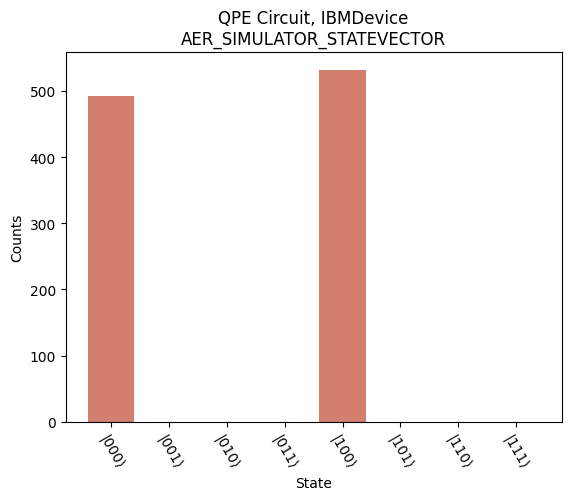

None


In [198]:
from mpqp import *
from mpqp.gates import *

def eigenstate_1():
    c = QCircuit(1)
    c.add(H(0))
    return c

def unitary_Z():
    c = QCircuit(1)
    c.add(H(0))
    return c

unitary = unitary_Z()
eigenstate = eigenstate_1()

qpe_circuit = QPE(
    unitary=unitary,
    eigenstate_circuit=eigenstate,
    n_precision_qubits=3
)

print("\nFinal QPE Circuit:")
qpe_circuit.pretty_print()

# Simulate it
result = run(qpe_circuit, IBMDevice.AER_SIMULATOR_STATEVECTOR)
print(result)
print(result.plot())
